In [71]:
# H0: mean(control's SkinThickness) = mean(treatment's SkinThickness)
# H1: mean(control's SkinThickness) <= mean(treatment's SkinThickness)

BINS = 20

ALPHA = 0.05
CONFIDENCE = 0.95

X = "BMI"
Y = "SkinThickness"

X_THRESHOLD = 30

URL = (
    "https://course-resources.minerva.edu/uploaded_files/mu/00294342-2873/diabetes.csv"
)


## Setup

In [72]:
import pandas
import numpy

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy import stats
from typing import Iterable


In [73]:
df = pandas.read_csv(URL)
df = df[(df[X] != 0) & (df[Y] != 0)]


control = df[df[X] < X_THRESHOLD]
treatment = df[df[X] >= X_THRESHOLD]

## #descriptivestats

In [74]:
print(df.describe()[[X, Y]])
print(control.describe()[[X, Y]])
print(treatment.describe()[[X, Y]])


              BMI  SkinThickness
count  539.000000     539.000000
mean    32.895733      29.176252
std      6.871851      10.489706
min     18.200000       7.000000
25%     27.850000      22.000000
50%     32.800000      29.000000
75%     36.900000      36.000000
max     67.100000      99.000000
              BMI  SkinThickness
count  189.000000     189.000000
mean    25.887302      21.370370
std      2.834879       7.214817
min     18.200000       7.000000
25%     24.200000      17.000000
50%     26.200000      20.000000
75%     28.200000      27.000000
max     29.900000      39.000000
              BMI  SkinThickness
count  350.000000     350.000000
mean    36.680286      33.391429
std      5.244299       9.527125
min     30.000000      11.000000
25%     33.100000      27.250000
50%     35.500000      32.000000
75%     39.100000      40.000000
max     67.100000      99.000000


In [75]:
print(f"{X} median, {Y} median for whole dataset")
print(df[X].median(), df[Y].median())

BMI median, SkinThickness median for whole dataset
32.8 29.0


In [76]:
print(f"{X} median, {Y} median for control")
print(control[X].median(), control[Y].median())

BMI median, SkinThickness median for control
26.2 20.0


In [77]:
print(f"{X} median, {Y} median for treatment")
print(treatment[X].median(), treatment[Y].median())

BMI median, SkinThickness median for treatment
35.5 32.0


## #distributions

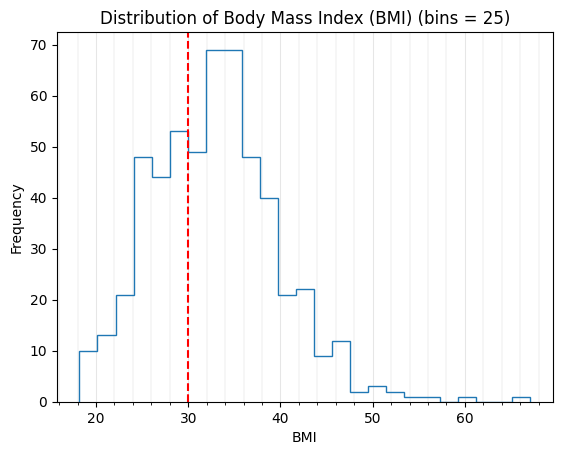

Mode of BMI is 31.891999999999996 <= BMI < 33.848


In [78]:
n_bins = 25

figure, ax = plt.subplots()
n, bins, _ = plt.hist(df[X], bins=n_bins, histtype="step")

ax.axvline(X_THRESHOLD, color="r", ls="--")
ax.set_title(f"Distribution of Body Mass Index (BMI) (bins = {n_bins})")
ax.set_xlabel(X)
ax.set_ylabel("Frequency")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.grid(which="major", axis="x", linewidth=0.75, linestyle="-", color="0.9")
ax.grid(which="minor", axis="x", linewidth=0.25, linestyle="-", color="0.8")
plt.savefig("figure1.png", dpi=600)
plt.show()

i = numpy.argmax(n)
lower = bins[i]
upper = bins[i + 1]
print(f"Mode of {X} is {lower} <= {X} < {upper}")


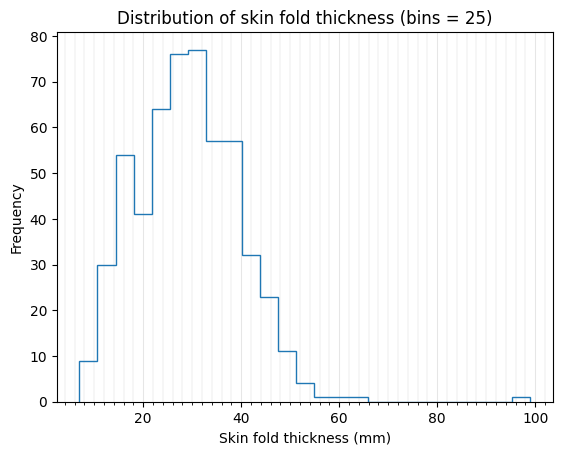

Mode of SkinThickness is 29.080000000000002 <= SkinThickness < 32.760000000000005


In [79]:
n_bins = 25

figure, ax = plt.subplots()
n, bins, _ = plt.hist(df[Y], bins=n_bins, histtype="step")

ax.set_title(f"Distribution of skin fold thickness (bins = {n_bins})")
ax.set_xlabel("Skin fold thickness (mm)")
ax.set_ylabel("Frequency")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.grid(which="major", axis="x", linewidth=0.75, linestyle="-", color="0.9")
ax.grid(which="minor", axis="x", linewidth=0.25, linestyle="-", color="0.8")
plt.savefig("figure2.png", dpi=600)
plt.show()

i = numpy.argmax(n)
lower = bins[i]
upper = bins[i + 1]
print(f"Mode of {Y} is {lower} <= {Y} < {upper}")


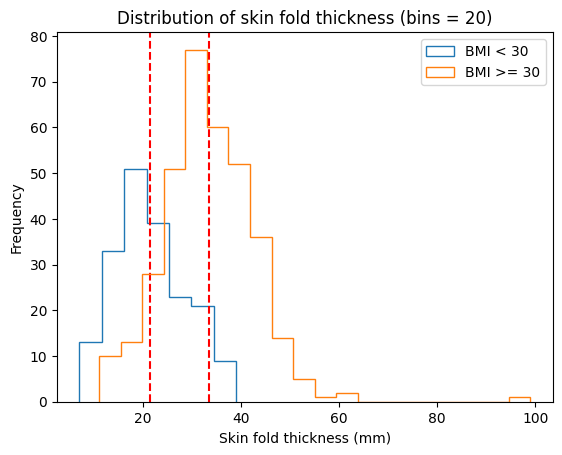

Mode of SkinThickness for control is 16.142857142857142 <= SkinThickness < 20.714285714285715
Mode of SkinThickness for treatment is 28.6 <= SkinThickness < 33.0


In [80]:
control_range = control[Y].max() - control[Y].min()
treatment_range = treatment[Y].max() - treatment[Y].min()
max_range = max(control_range, treatment_range)
control_bins = round(control_range / max_range * BINS)
treatment_bins = round(treatment_range / max_range * BINS)

figure, ax = plt.subplots()

n_1, bins_1, _ = ax.hist(
    control[Y],
    label=f"{X} < {X_THRESHOLD}",
    bins=control_bins,
    histtype="step",
)

ax.axvline(numpy.mean(control[Y]), color="r", ls="--")

n_2, bins_2, _ = ax.hist(
    treatment[Y],
    label=f"{X} >= {X_THRESHOLD}",
    bins=treatment_bins,
    histtype="step",
)
ax.axvline(numpy.mean(treatment[Y]), color="r", ls="--")

ax.set_title(f"Distribution of skin fold thickness (bins = {BINS})")
ax.set_xlabel("Skin fold thickness (mm)")
ax.set_ylabel("Frequency")
plt.legend()
plt.savefig("figure3.png", dpi=600)
plt.show()

i = numpy.argmax(n_1)
lower = bins_1[i]
upper = bins_1[i + 1]
print(f"Mode of {Y} for control is {lower} <= {Y} < {upper}")

i = numpy.argmax(n_2)
lower = bins_2[i]
upper = bins_2[i + 1]
print(f"Mode of {Y} for treatment is {lower} <= {Y} < {upper}")


## #significance

In [81]:
def difference_of_means_test(
    control: Iterable[float], treatment: Iterable[float], tails: int = 1
):
    n_1, n_2 = len(control), len(treatment)
    x_1, x_2 = numpy.mean(control), numpy.mean(treatment)

    # sample SD formula (aka Bessel’s correction): use n-1 in denominator
    s_1, s_2 = numpy.std(control, ddof=1), numpy.std(treatment, ddof=1)

    # conservative estimate from OpenIntro
    DOF = min(n_1, n_2) - 1

    SE = numpy.sqrt(s_1**2 / n_1 + s_2**2 / n_2)
    t_score = numpy.abs((x_2 - x_1)) / SE
    p_value = tails * stats.t.cdf(-t_score, DOF)

    # OpenIntro section 5.3.6
    pooled_SD = numpy.sqrt(
        (s_1**2 * (n_1 - 1) + s_2**2 * (n_2 - 1)) / (n_1 + n_2 - 2)
    )
    cohen_d = (x_2 - x_1) / pooled_SD

    return p_value, cohen_d


In [82]:
p_value, cohen_d = difference_of_means_test(
    control[Y], treatment[Y]
)
print(f"p-value: {p_value}, Cohen's d: {cohen_d}")


p-value: 1.6038765846192836e-38, Cohen's d: 1.3680347642319406


## Central Limit Theorem

In [83]:
# this function implements the full sampling process
def sample_procedure(pop_dist, n, repeats):
    sample_means = []

    for i in range(repeats):
        sample = numpy.random.choice(pop_dist, n)
        # by default, numpy.random.choice uses replace=True
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
    return sample_means


# this function creates an upper and lower bound for a confidence interval
def confidence_interval(point_estimate, SE, conf_level):
    z = stats.norm.ppf(
        1 - (1 - conf_level) / 2
    )  # gives 1.96 for a 95% confidence level
    lowbound = point_estimate - z * SE
    highbound = point_estimate + z * SE
    return lowbound, highbound


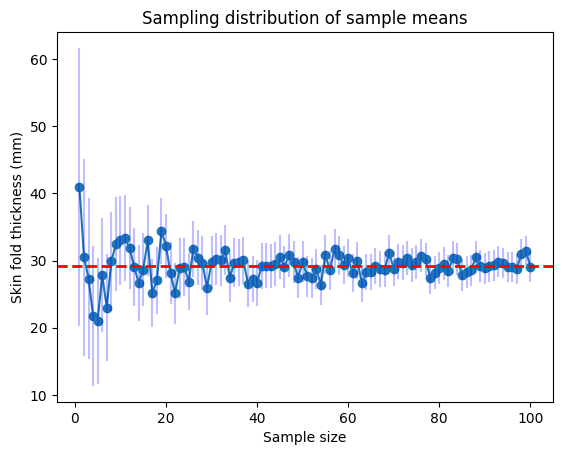

In [84]:
max_sample_size = 100
population = df[Y]
SD = numpy.std(population)

sample_means = []
cis = []
for sample_size in range(1, max_sample_size + 1):
    SE = SD / numpy.sqrt(sample_size)
    sample = numpy.random.choice(population, sample_size)
    sample_mean = numpy.mean(sample)
    sample_means.append(sample_mean)
    cis.append(confidence_interval(sample_mean, SE, CONFIDENCE))

plt.scatter(range(1, max_sample_size + 1), sample_means)
plt.plot(range(1, max_sample_size + 1), sample_means)

for i in range(len(cis)):
    plt.plot([i + 1, i + 1], cis[i], color="b", alpha=0.25)

plt.axhline(numpy.mean(population), color="r", linestyle="--", linewidth=2)
plt.title("Sampling distribution of sample means")
plt.xlabel("Sample size")
plt.ylabel("Skin fold thickness (mm)")
plt.savefig("figure4.png", dpi=600)
plt.show()
